Rebuilding the Dupuis+ spot model

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import astropy.io.fits as fits
import os
import glob
from astropy.table import Table
from astropy.io import ascii
import astropy.units as u
import astropy.constants as const
from astropy.modeling import models, fitting
import lightkurve as lk
import matplotlib.gridspec as gridspec
import scipy.interpolate as interpolate
from matplotlib.gridspec import GridSpec

#matplotlib set up
%matplotlib inline
from matplotlib import rcParams
rcParams["figure.figsize"] = (14, 5)
rcParams["font.size"] = 20

In [3]:
def spot(phi, gamma, U =2.784, kw=0.):
    eps0, reg, d = coverage(phi, gamma) 
    c = U*(1-(1-kw)*eps0)
    return c, eps0, reg, d

def coverage(phi, gamma):
    k = np.sin(gamma)
    z0 = get_z0(phi)
    d = ((1-k**2)*(1-z0**2))**0.5 
    if  d <= (1 - k**2) and gamma >=np.pi/2:
        eps = 1.0
        reg= 1
    elif  d <= (1 - k**2):
        reg= 2
        eps = (k**2)*z0
    elif  d > (1 - k**2):
        reg= 3
        s = (1 - k**2)/d 
        v = (d - s) / (k*z0)
        eps = (1/np.pi) *( np.arccos(s) - (s*(1-s**2)**0.5) + ( (k**2) * z0*(np.arccos(v) - (v*(1-v**2)**0.5))))
        
    if eps < 0:
        eps = 0 #hack? I guess? It fixes it?
        
    return eps, reg, d

def get_z0(phi, beta = 43.193*np.pi/180, i =np.pi/2, lam=np.pi):
    z0 = np.cos(lam - phi) * np.cos(beta) * np.sin(i) + np.sin(beta) * np.cos(i)
    return z0



2.784
2.0982292833105083


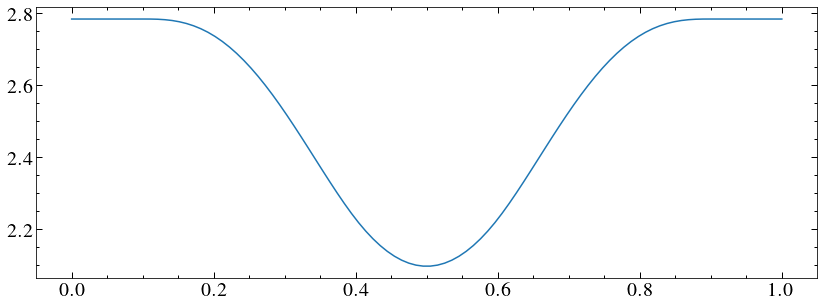

In [4]:
phi = np.linspace(0, 360, 100)
#ds = [np.tan((1-p)*np.pi) for p in phi]
gamma = 35.55*np.pi/180
counts = np.array([spot(p*np.pi/180, gamma) for p in phi])
plt.plot(phi/360, counts[:,0])
#plt.plot(phi, counts[:,1])
#plt.plot(phi, counts[:,2])
#plt.plot(phi, counts[:,3])
#plt.axhline(2.78)
#plt.axvline(90)
#plt.axvline(270)
print(max(counts[:,0]))
print(min(counts[:,0]))

In [5]:
savdat = Table([phi/360, counts[:,0]],names=['PHASE', 'COUNTS'])
ascii.write(savdat, 'spot_model.ecsv', format='ecsv', overwrite=True)

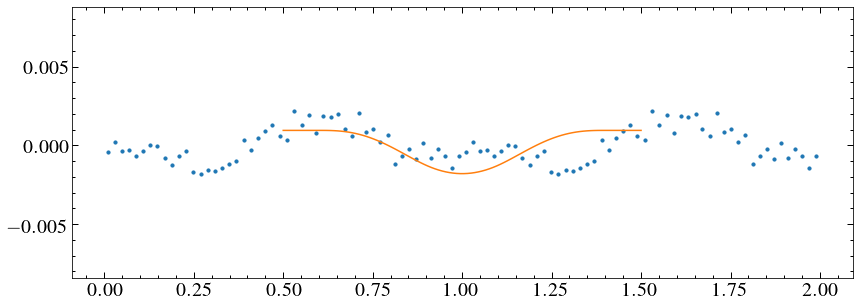

In [6]:
data = fits.getdata('folded_joint_lc.fits', 1)
t, f, e = data['TIME'], data['FLUX'], data['FLUX_ERR']
lc_fold = lk.LightCurve(time=t, flux=f, flux_err=e ).remove_outliers(sigma=5)

pbin =int(len(lc_fold.time)/50)

#plt.ylim(-0.009, 0.009)
plt.scatter(lc_fold.bin(pbin).time+0.5, lc_fold.bin(pbin).flux, s=10, c='C0')
plt.scatter(lc_fold.bin(pbin).time+1.5, lc_fold.bin(pbin).flux, s=10, c='C0')

fl = lc_fold.bin(pbin).flux
phase, mod = phi/360, counts[:,0]
#scale = (max(mod)/min(mod)) * abs((max(fl)/min(fl)))
plt.plot(phase+0.5, (mod-np.mean(mod))/250, c='C1')

In [7]:
25/0.1

250.0

Compare with actual EUVE data?

In [8]:
et, ef, ee = np.loadtxt('euve_lc/ds_5760_ltc_obs2.ascii', unpack=True)

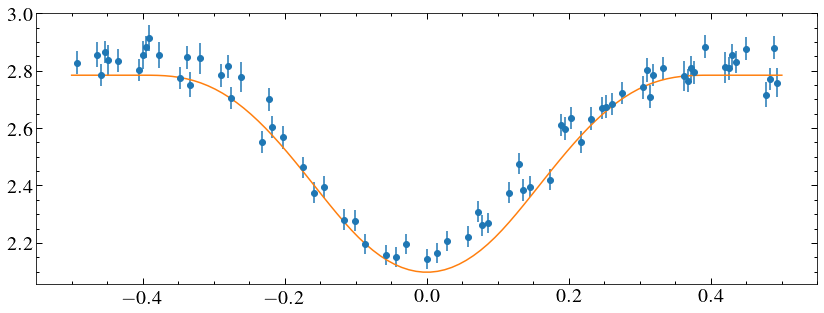

In [9]:
euve_lc = lk.LightCurve(time=et/86400, flux=ef, flux_err=ee)
#plt.errorbar(euve_lc.time, euve_lc.flux, yerr=euve_lc.flux_err, marker='o', ls='none')
t0 = euve_lc.time[np.where(ef == np.min(ef))[0][0]]
efold = euve_lc.fold(1.15, t0 = t0)
plt.errorbar(efold.time, efold.flux, yerr=efold.flux_err, marker='o', ls='none')
plt.plot(phase-0.5, mod, c='C1')

693


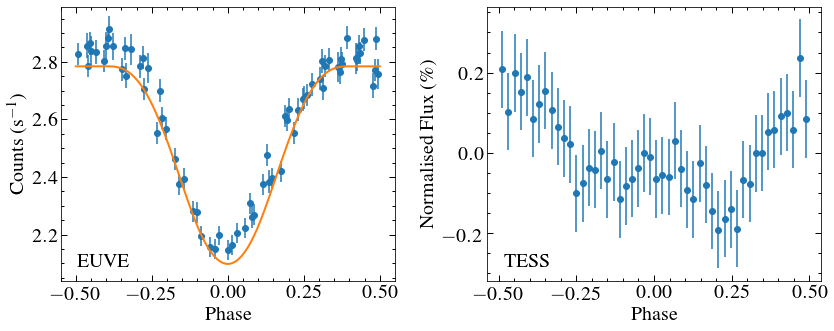

In [10]:
#eph = 2458737.560(0.018)

plt.figure(figsize=(12,5))

plt.subplot(121)
#t0 = euve_lc.time[np.where(ef == np.min(ef))[0][0]]
t0 =50004.27+0.5
efold = euve_lc.fold(1.15, t0 = t0)
plt.errorbar(efold.time, efold.flux, yerr=efold.flux_err, marker='o', ls='none')
 
plt.plot(phase-0.5, mod, c='C1', lw=2, zorder=10)
plt.xlabel('Phase')
plt.ylabel('Counts (s$^{-1}$)')
plt.annotate('EUVE', (0.05,0.05), xycoords='axes fraction' )
plt.ylim(2.04, 2.99)

plt.subplot(122)
data = fits.getdata('joint_lc.fits', 1)
t, f, e = data['TIME'], data['FLUX'], data['FLUX_ERR']
lc = lk.LightCurve(time=t, flux=f, flux_err=e ).remove_outliers(sigma=5)
print(pbin)
lc_fold2 = lc.fold(1.1468, t0 =2458737.560 ).bin(pbin)
plt.errorbar(lc_fold2.time, lc_fold2.flux*100, yerr=lc_fold2.flux_err*100, marker='o', ls='none')
plt.xlabel('Phase')
plt.ylabel('Normalised Flux (\%)')
plt.annotate('TESS', (0.05,0.05), xycoords='axes fraction' )

plt.tight_layout()
#plt.savefig('plots/euve_v_tess.pdf', dpi=150)

#plt.scatter(lc_fold.bin(pbin).time, lc_fold.bin(pbin).flux, s=10, c='C1')

Can I get the model to fit the TESS data by tweaking the model opacity? Need the un-normalised TESS data

461.29333


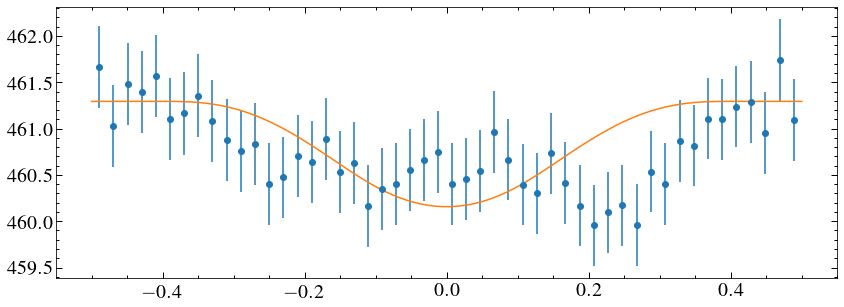

In [11]:
tessfits = glob.glob('tess_fits_files/*fits')
data = fits.getdata(tessfits[0],1)
t, f, e, q = data['TIME'], data['PDCSAP_FLUX'], data['PDCSAP_FLUX_ERR'], data['QUALITY']
t, f, e = t[q==0], f[q==0], e[q==0]
lc1 = lk.LightCurve(time=t, flux=f, flux_err=e ).remove_outliers(sigma=5)

data = fits.getdata(tessfits[1],1)
t, f, e, q = data['TIME'], data['PDCSAP_FLUX'], data['PDCSAP_FLUX_ERR'], data['QUALITY']
t, f, e = t[q==0], f[q==0], e[q==0]
lc2 = lk.LightCurve(time=t, flux=f, flux_err=e ).remove_outliers(sigma=5)

lc = lc1.append(lc2)
lcfold = lc.fold(1.1468, t0 =2458737.560 ).bin(pbin)
plt.errorbar(lcfold.time, lcfold.flux, yerr=lcfold.flux_err, marker='o', ls='none')


phi = np.linspace(0, 360, 100)
#ds = [np.tan((1-p)*np.pi) for p in phi]
utess = np.mean(lcfold.flux[lcfold.flux > 461])
print(utess)
gamma = 35.55*np.pi/180
counts = np.array([spot(p*np.pi/180, gamma, U =utess, kw=0.99) for p in phi])
plt.plot((phi/360)-0.5, counts[:,0])

making a fittable spot model

In [12]:
from astropy.modeling.models import custom_model
from astropy.modeling.fitting import LevMarLSQFitter

@custom_model
def spot_model(x, gamma=1, U=1, kw=0., beta=0, i = np.pi/2, lam=np.pi):
    #phi = np.linspace(0, 360, 100)
    y = np.array([counts_at_phi(p*2*np.pi, gamma, U, kw, beta, i, lam) for p in x+0.5])
    return y
    

def counts_at_phi(phi, gamma, U, kw, beta, i, lam):
    z0 = get_z0(phi, beta, i, lam)
    eps0, reg, d = coverage(phi, gamma, z0) 
    c = U*(1-(1-kw)*eps0)
    return c

def coverage(phi, gamma, z0):
    k = np.sin(gamma)
    d = ((1-k**2)*(1-z0**2))**0.5 
    if  d <= (1 - k**2) and gamma >=np.pi/2:
        eps = 1.0
        reg= 1
    elif  d <= (1 - k**2):
        reg= 2
        eps = (k**2)*z0
    elif  d > (1 - k**2):
        reg= 3
        s = (1 - k**2)/d 
        v = (d - s) / (k*z0)
        eps = (1/np.pi) *( np.arccos(s) - (s*(1-s**2)**0.5) + ( (k**2) * z0*(np.arccos(v) - (v*(1-v**2)**0.5))))
        
    if eps < 0:
        eps = 0 #hack? I guess? It fixes it?
        
    return eps, reg, d

def get_z0(phi, beta, i, lam):
    z0 = np.cos(lam - phi) * np.cos(beta) * np.sin(i) + np.sin(beta) * np.cos(i)
    return z0

In [13]:
def calc_reduced_chi_square(fit, x, y, yerr, N, n_free):
    '''
    http://learn.astropy.org/rst-tutorials/User-Defined-Model.html
    fit (array) values for the fit
    x,y,yerr (arrays) data
    N total number of points
    n_free number of parameters we are fitting
    '''
    return 1.0/(N-n_free)*sum(((fit - y)/yerr)**2)

findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.


[0.36398206 0.00037059]
0.997505803382184
89.99682632790099
Model: spot_model
Inputs: ('x',)
Outputs: ('y',)
Model set size: 1
Parameters:
          gamma                U          ...         i                 lam       
    ------------------ ------------------ ... ------------------ -----------------
    1.5707409357673903 461.33026123046875 ... 1.5707963267948966 3.141592653589793
0.990345218363949
[0.00111123]
0.5315361850281242
1.0745106156012634


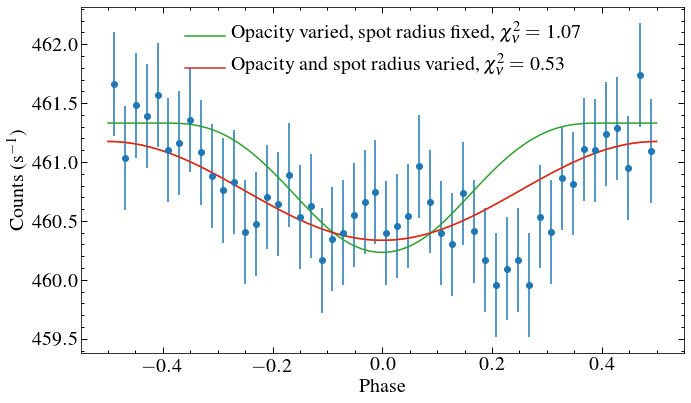

In [14]:
#from scipy.stats import chisquare

plt.figure(figsize=(10,6))
utess = np.mean([np.mean(lcfold.flux[:5]), np.mean(lcfold.flux[-6:])])
dgamma = 35.55*np.pi/180
dbeta = 43.193*np.pi/180 
m_init = spot_model(gamma=dgamma, U=utess, kw = 0.9, beta=dbeta, fixed=dict(gamma=False, U=True, beta=True, i=True, lam=True))#, bounds = dict(kw=[0.7, 0.9999]))
fit = LevMarLSQFitter()
m = fit(m_init, lcfold.time,lcfold.flux, weights=1/lcfold.flux_err, maxiter=100000)
fit_e = np.sqrt(np.diag(fit.fit_info['param_cov']))
print(fit_e)
print(m.kw.value)
#print(m.beta*180/np.pi)
print(m.gamma*180/np.pi)
#print(m.i*180/np.pi)
print(m)
plt.errorbar(lcfold.time, lcfold.flux, yerr=lcfold.flux_err, marker='o', ls='none')
timefit = np.linspace(-0.5,  0.5, 100)
plt.plot(timefit, m(timefit))

m_init2 = spot_model(gamma=dgamma, U=utess, kw = 0.9, beta=dbeta, fixed=dict(gamma=True, U=True, beta=True, i=True, lam=True))#, bounds = dict(kw=[0.7, 0.9999]))
m2 = fit(m_init2, lcfold.time,lcfold.flux, weights=1/lcfold.flux_err, maxiter=100000)
fit_e2 = np.sqrt(np.diag(fit.fit_info['param_cov']))
print(m2.kw.value)
print(fit_e2)

#chi_square1 = np.sum(((lcfold.flux-m(lcfold.time))**2)/lcfold.flux_err**2)/(len(lcfold.time)-2)
#chi_square = np.sum((lcfold.flux-m(lcfold.time))**2)
chi_square1 = calc_reduced_chi_square(m(lcfold.time), lcfold.time , lcfold.flux, lcfold.flux_err, len(lcfold.time), 2)
print(chi_square1)

chi_square2 = calc_reduced_chi_square(m2(lcfold.time), lcfold.time , lcfold.flux, lcfold.flux_err, len(lcfold.time), 1)
#chi_square2 = np.sum(((lcfold.flux-m2(lcfold.time))**2)/lcfold.flux_err**2)/(len(lcfold.time)-1)
#chi_square = np.sum((lcfold.flux-m(lcfold.time))**2)
print(chi_square2)


#print(chisquare(lcfold.flux, m(lcfold.time), ddof=2))

plt.plot(timefit, m2(timefit), label = r'Opacity varied, spot radius fixed, $\chi^{{2}}_{{\nu}}=${0:10.2f}'.format(chi_square2))
plt.plot(timefit, m(timefit), label = r'Opacity and spot radius varied, $\chi^{{2}}_{{\nu}}=${0:10.2f}'.format(chi_square1))
plt.legend()
plt.xlabel('Phase')
plt.ylabel('Counts (s$^{-1}$)')
plt.tight_layout()
plt.savefig('tess_model_fits.pdf')
#plt.plot(lcfold.time, m(lcfold.time-0.5))
#plt.plot(timefit, m_init(timefit))

In [15]:
print(np.mean(lcfold.flux/m2(lcfold.time)))
print(np.mean(lcfold.flux/m(lcfold.time)))

0.9995938280558739
1.0000061405393805


spot_r$\chi^2$ = 2.845719048101062
sin_r$\chi^2$ = 4.4049501800318005
0.9904087133449109
[0.00166193]
spot_r$\chi^2$ = 2.40037996048046
sin_r$\chi^2$ = 0.9472953234753095


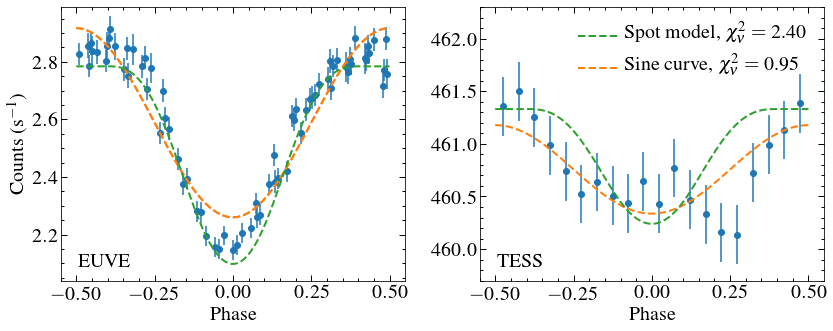

In [49]:
plt.figure(figsize=(12,5))
timefit = np.linspace(-0.5,  0.5, 100)
plt.subplot(121)
#t0 = euve_lc.time[np.where(ef == np.min(ef))[0][0]]
t0 =50004.27+0.5
efold = euve_lc.fold(1.15, t0 = t0)
plt.errorbar(efold.time, efold.flux, yerr=efold.flux_err, marker='o', ls='none')
emod = spot_model(gamma=dgamma, U=2.784, kw = 0, beta=dbeta, fixed=dict(gamma=True, U=True, beta=True, i=True, lam=True))

#plt.plot(phase-0.5, mod, c='C1', lw=2, zorder=10, ls='--')
plt.plot(timefit, emod(timefit), c='C2', lw=2, zorder=10, ls='--')
plt.xlabel('Phase')
plt.ylabel('Counts (s$^{-1}$)')
plt.annotate('EUVE', (0.05,0.05), xycoords='axes fraction' )
plt.ylim(2.04, 2.99)
spot_chi  = calc_reduced_chi_square(emod(efold.time), efold.time , efold.flux, efold.flux_err, len(efold.time), 2)
print('spot_r$\chi^2$ = {}'.format(spot_chi))


#see if I can fit EUVE with a sine curve
esin_init =  models.Sine1D(amplitude=1, frequency=1, phase = 0.25, fixed={'frequency':True, 'phase':True}) + models.Const1D(np.mean(efold.flux))
esin_fit = fit(esin_init, efold.time, efold.flux, weights = 1/efold.flux_err)
esin_fit_e = np.sqrt(np.diag(fit.fit_info['param_cov']))
plt.plot(timefit, esin_fit(timefit), ls='--', lw=2, zorder=9)
#print(esin_fit)
plt.plot(timefit, esin_fit(timefit), ls='--', lw=2, zorder=9, c='C1')

sin_chi  = calc_reduced_chi_square(esin_fit(efold.time), efold.time , efold.flux, efold.flux_err, len(efold.time), 1)
print(r'sin_r$\chi^2$ = {}'.format(sin_chi))

plt.subplot(122)
pbin =int(len(lc_fold.time)/20)
lcfold = lc.fold(1.1468, t0 =2458737.560 ).bin(pbin)
#m99 = spot_model(gamma=dgamma, U=utess, kw = 0.99, beta=dbeta) #nominal k=0.99 model
m_init2 = spot_model(gamma=dgamma, U=utess, kw = 0.99, beta=dbeta, fixed=dict(gamma=True, U=True, beta=True, i=True, lam=True))#, bounds = dict(kw=[0.7, 0.9999]))
m2 = fit(m_init2, lcfold.time,lcfold.flux, weights=1/lcfold.flux_err, maxiter=100000)
fit_e2 = np.sqrt(np.diag(fit.fit_info['param_cov']))
print(m2.kw.value)
print(fit_e2)


spot_chi  = calc_reduced_chi_square(m2(lcfold.time), lcfold.time , lcfold.flux, lcfold.flux_err, len(lcfold.time), 1)
print('spot_r$\chi^2$ = {}'.format(spot_chi))

plt.errorbar(lcfold.time, lcfold.flux, yerr=lcfold.flux_err, marker='o', ls='none')

#plt.plot(timefit, m(timefit))
plt.plot(timefit, m2(timefit), ls='--', lw=2, zorder=10, label = r'Spot model, $\chi^{{2}}_{{\nu}}=${0:10.2f}'.format(spot_chi), c='C2')

fold_mod =  models.Sine1D(amplitude=10, frequency=1, phase = 0.25, fixed={'frequency':True, 'phase':True}) + models.Const1D(450)
fold_fit = fit(fold_mod, lcfold.time, lcfold.flux, weights = 1/lcfold.flux_err)
fold_fit_e = np.sqrt(np.diag(fit.fit_info['param_cov']))
sin_chi  = calc_reduced_chi_square(fold_fit(lcfold.time), lcfold.time , lcfold.flux, lcfold.flux_err, len(lcfold.time), 1)
plt.plot(timefit, fold_fit(timefit), ls='--', lw=2, zorder=9, label = r'Sine curve, $\chi^{{2}}_{{\nu}}=${0:10.2f}'.format(sin_chi), c='C1')
#print(fold_fit)

print(r'sin_r$\chi^2$ = {}'.format(sin_chi))

plt.legend()
plt.ylim(459.7, 462.3)
plt.xlabel('Phase')
#plt.ylabel('Normalised Flux (\%)')
plt.annotate('TESS', (0.05,0.05), xycoords='axes fraction' )

plt.tight_layout()
#plt.show()
#plt.scatter(lcfold.time, lcfold.flux/m(lcfold.flux))
plt.savefig('plots/euve_v_tess_mod_sin.pdf', dpi=150)

In [17]:
#print(chisquare(efold.flux, interpolate.interp1d(phase-0.5,mod)(efold.time)))
#chi_square = np.sum(((efold.flux-interpolate.interp1d(phase-0.5,mod)(efold.time))/efold.flux_err)**2)/(len(efold.time)-2)
#print(chi_square)

In [18]:
fit.fit_info

{'nfev': 7,
 'fvec': array([-0.66169934, -1.32356172, -0.71101782, -0.14092285,  0.30649297,
         0.60018238, -0.2536026 , -0.16301281, -0.18281405, -1.07548379,
        -0.3264117 , -1.40966819, -0.05543843,  0.82801258,  1.89118656,
         2.43913089,  0.78002749,  0.21086015, -0.01072528, -0.76619826]),
 'fjac': array([[-1.60154614e+01,  2.23254100e-01,  2.23054275e-01,
          2.22434926e-01,  2.23055659e-01,  2.23792510e-01,
          2.23585763e-01,  2.23146662e-01,  2.22964523e-01,
          2.22929271e-01,  2.23225488e-01,  2.24605254e-01,
          2.24521888e-01,  2.24313696e-01,  2.24386894e-01,
          2.24319532e-01,  2.24036579e-01,  2.24262649e-01,
          2.23996816e-01,  2.23256780e-01],
        [-8.57585838e-02,  1.13206667e+01,  1.68018089e-01,
          8.77848786e-02, -5.98000224e-03, -1.05072982e-01,
         -1.99105671e-01, -2.78202577e-01, -3.35166513e-01,
         -3.66088388e-01, -3.68296626e-01, -3.41846005e-01,
         -2.84771201e-01, -2.04954

In [19]:
a = np.array([16, 18, 16, 14, 12, 12], dtype=float) 
b=np.array([16, 16, 16, 16, 16, 8], dtype=float)
print(np.sum(((a-b)**2)/b))
#chisquare(a,b)

3.5


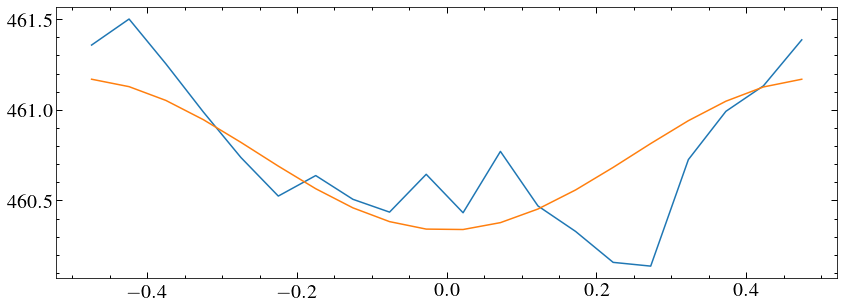

In [20]:
plt.plot(lcfold.time, lcfold.flux)
plt.plot(lcfold.time, m(lcfold.time))

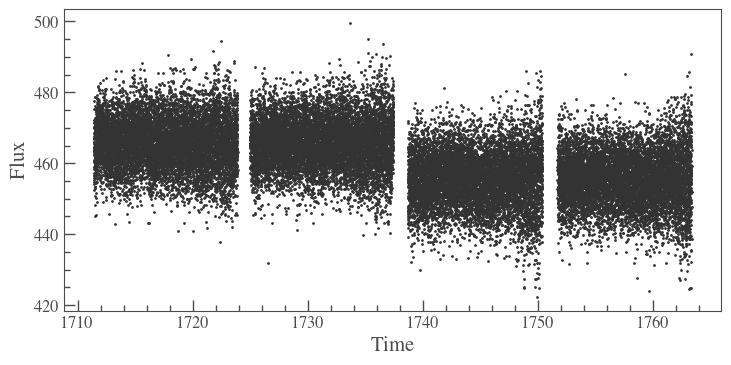

In [21]:
lc.scatter()

STIS lightcurve - just intergrate the flux on each spectrum? Check what I did a few months ago

In [29]:
"""stis_lcs = glob.glob('../inttag/*100s_lc.ecsv')
fitter = fitting.LevMarLSQFitter()
stime, sflux, serror = np.array([], dtype=float), np.array([], dtype=float), np.array([], dtype=float)
for i, lcpath in enumerate(stis_lcs):
    data = Table.read(lcpath)
    t, f, e = data['TIME'], data['FLUX'], data['ERROR']
    plt.errorbar(t, f, yerr=e, marker='o', ls='none' )
    fm = np.mean(f)
    rootname = os.path.split(lcpath)[1][:-13]
    hsthorb = fits.getheader('../inttag/data/{}_spt.fits'.format(rootname))['HSTHORB']
    period = hsthorb *u.s.to(u.day)*2
    sin_mod =  models.Sine1D(amplitude=np.std(f), frequency=1/period, fixed=dict(frequency=True)) +  models.Const1D(fm)
    sin_fit = fitter(sin_mod, t, f, weights= 1/e, maxiter=1000000)
    fit_e = np.sqrt(np.diag(fitter.fit_info['param_cov']))
    timefit = np.linspace(t[0], t[-1], 100)
    plt.plot(timefit, sin_fit(timefit))
    fn = f-sin_fit[0](t)
    plt.errorbar(t, fn, yerr=e, marker='o', ls='none' )
    plt.show()
    stime = np.concatenate((stime, t))
    sflux = np.concatenate((sflux, fn))
    serror = np.concatenate((serror, e))
args = np.argsort(stime)
stime, sflux, serror = stime[args], sflux[args], serror[args]
lc_stis = lk.LightCurve(time=stime, flux=(sflux/np.mean(sflux))-1, flux_err=serror/np.mean(sflux))
#plt.errorbar(stime, sflux, yerr=serror, marker='o', ls='none' )
lcs_fold = lc_stis.fold(1.1468, t0 =2458737.560 )
plt.errorbar(lcs_fold.time, lcs_fold.flux, yerr=lcs_fold.flux_err, marker='o', ls='none' )
plt.show()
pgs= lc_stis.to_periodogram(oversample_factor=10,minimum_period=4*u.minute, maximum_period=2.5*u.day)
plt.plot(pgs.period, pgs.power)
plt.axvline(1.1468)
plt.show()


fig = plt.figure(figsize=(8, 5))
gs = GridSpec(1, 3, figure=fig)

#plt.subplot(gs[:2])
plt.errorbar(lcs_fold.time, lcs_fold.flux*100, yerr=lcs_fold.flux_err*100, marker='o', ls='none' , c='C0')
#plt.errorbar(lcs_fold.time+1, lcs_fold.flux*100, yerr=lcs_fold.flux_err*100, marker='o', ls='none', c ='C0')
plt.ylabel('Normalised Flux (\%)', size=20)
plt.xlabel('Phase', size=20)

#plt.subplot(gs[2:])
#plt.plot(pgs.period, pgs.power*100)
#plt.xscale('log')
#plt.ylabel('Amplitude (\%)', size=20)
#plt.xlabel('Period (d)', size=20)
#plt.xlim(1/24, 10)
#plt.axvline(1.1468, ls='--', c='C1', lw=2)
#plt.annotate()
plt.tight_layout()
plt.savefig('plots/stis_lc_eg.pdf')
#plt.savefig('plots/tyc1854-1814-1_tess.pdf')
"""

"stis_lcs = glob.glob('../inttag/*100s_lc.ecsv')\nfitter = fitting.LevMarLSQFitter()\nstime, sflux, serror = np.array([], dtype=float), np.array([], dtype=float), np.array([], dtype=float)\nfor i, lcpath in enumerate(stis_lcs):\n    data = Table.read(lcpath)\n    t, f, e = data['TIME'], data['FLUX'], data['ERROR']\n    plt.errorbar(t, f, yerr=e, marker='o', ls='none' )\n    fm = np.mean(f)\n    rootname = os.path.split(lcpath)[1][:-13]\n    hsthorb = fits.getheader('../inttag/data/{}_spt.fits'.format(rootname))['HSTHORB']\n    period = hsthorb *u.s.to(u.day)*2\n    sin_mod =  models.Sine1D(amplitude=np.std(f), frequency=1/period, fixed=dict(frequency=True)) +  models.Const1D(fm)\n    sin_fit = fitter(sin_mod, t, f, weights= 1/e, maxiter=1000000)\n    fit_e = np.sqrt(np.diag(fitter.fit_info['param_cov']))\n    timefit = np.linspace(t[0], t[-1], 100)\n    plt.plot(timefit, sin_fit(timefit))\n    fn = f-sin_fit[0](t)\n    plt.errorbar(t, fn, yerr=e, marker='o', ls='none' )\n    plt.show()

Just using the integrated flux from each spectrum

In [ ]:
"""phases = [0, 0.25]
xaxis = np.linspace(0, 1, 100)
for phase in phases:
    mod = models.Sine1D(amplitude=1, frequency=1, phase = phase)
    plt.plot(xaxis, mod(xaxis), label=phase)
plt.legend()"""

Checking where that bump in the lightcurve comes from -take out chunks?

In [40]:
p0, t0 = 1.1468, 2458737.560

"""
#34658
gaps = np.arange(0, len(lc.time), 3000)
for i, g in enumerate(gaps):
    #lccut = lc[:gaps[i]].append(lc[gaps[i+1]:])
    lccut = lc[gaps[i]:gaps[i+1]]
    lcf= lccut.fold(p0, t0=t0).bin(50)
    lcf.errorbar()
"""

'p0, t0 = 1.1468, 2458737.560\n#34658\ngaps = np.arange(0, len(lc.time), 3000)\nfor i, g in enumerate(gaps):\n    #lccut = lc[:gaps[i]].append(lc[gaps[i+1]:])\n    lccut = lc[gaps[i]:gaps[i+1]]\n    lcf= lccut.fold(p0, t0=t0).bin(50)\n    lcf.errorbar()\n'

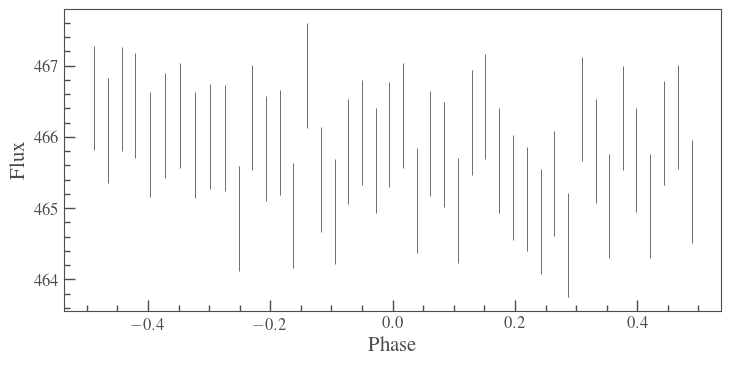

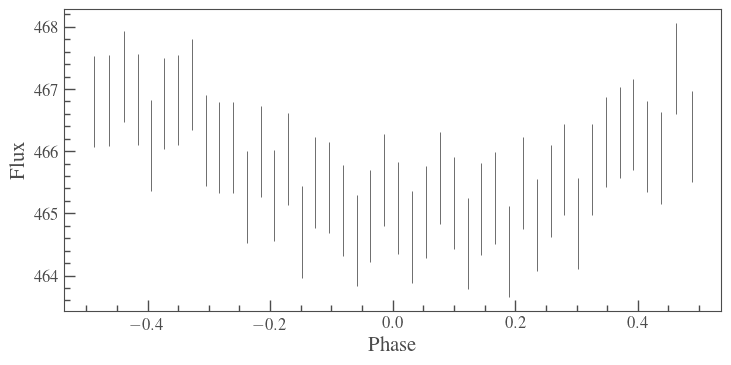

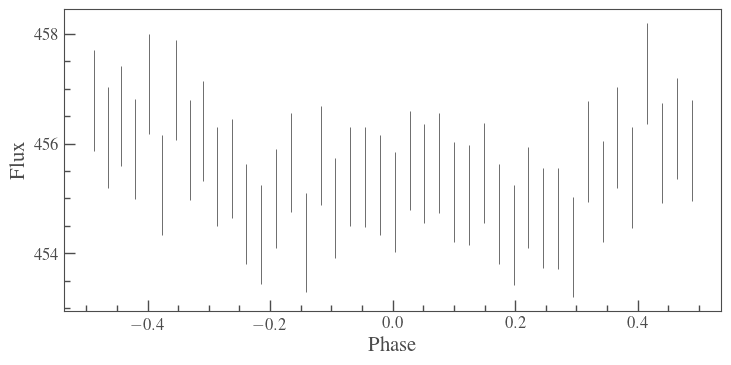

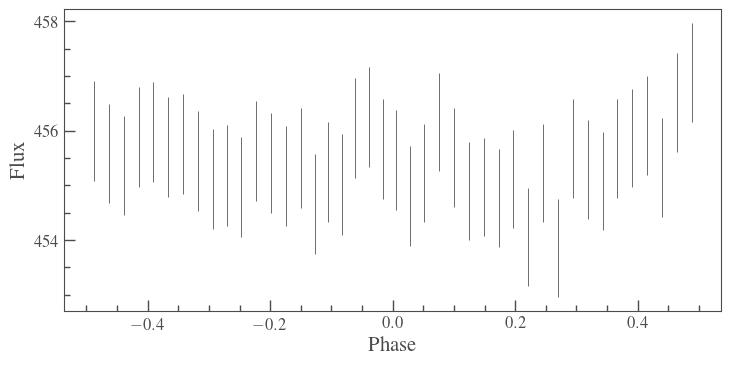

In [48]:
lc1[:int(len(lc1)/2)].fold(p0, t0=t0).bin(200).errorbar()
lc1[int(len(lc1)/2):].fold(p0, t0=t0).bin(200).errorbar()
lc2[:int(len(lc2)/2)].fold(p0, t0=t0).bin(200).errorbar()
lc2[int(len(lc2)/2):].fold(p0, t0=t0).bin(200).errorbar()


1732